In [5]:
# Colab Setup (Run this first)

In [7]:
!pip install litebird_sim rich

  Cloning https://github.com/galsci/pysm.git (to revision f220a4e) to /tmp/pip-install-to3_ew95/pysm3_c02013af6ee24f81bdc3696d0bde713b
  Running command git clone --filter=blob:none --quiet https://github.com/galsci/pysm.git /tmp/pip-install-to3_ew95/pysm3_c02013af6ee24f81bdc3696d0bde713b


  Running command git checkout -q f220a4e
  Resolved https://github.com/galsci/pysm.git to commit f220a4e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# `litebird_sim` beam convolution

To run this notebook, you have several options:

-   If you are running this under Binder, you should already be set!
-   If you are running this under Google Colab, be sure to run the cell with `!pip install…` that is right above the title.
-   If you are running this locally, you should first create and activate a new virtual environment with the commands

    ```
    python -m venv ./my_venv
    source ./my_venv/bin/activate
    ```

    (you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

    ```
    pip install jupyter litebird_sim
    ```

    If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a _development install_ instead:

    ```
    cd /my/local/copy/litebird_sim
    pip install -e .
    ```


## Import Modules

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import litebird_sim as lbs
from litebird_sim import mpi
from litebird_sim.hwp_sys.hwp_sys import mueller_interpolation

## Define Parameters

In [ ]:
start_time = 0
time_span_s = 365 * 24 * 3600
nside = 128
sampling = 19
hwp_radpsec = lbs.IdealHWP(
    46 * 2 * np.pi / 60,
).ang_speed_radpsec

lbs.PTEP_IMO_LOCATION = "schema.json"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
imo_version = "IMo_vReformationPlan_Option1M"

## Create Simulation

In [ ]:
sim = lbs.Simulation(
    start_time=start_time, duration_s=time_span_s, random_seed=0, imo=imo
)

comm = sim.mpi_comm

## Define Frequency Channel

In [ ]:
channel = "MF1_140"

channelinfo = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/LMHFT/{channel}/channel_info",
    imo=imo,
)

## Define Scanning Strategy

In [ ]:
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/Observation/Scanning_Strategy"
)

## Define Instrument

In [ ]:
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/LMHFT/instrument_info",
    )
)

## Set HWP

In [ ]:
sim.set_hwp(lbs.IdealHWP(hwp_radpsec))

## Define Detectors

In [ ]:
det = lbs.DetectorInfo.from_imo(
    url=f"/releases/{imo_version}/LMHFT/{channel}/{channelinfo.detector_names[0]}/detector_info",
    imo=imo,
)

theta = det.pointing_theta_phi_psi_deg[0]

det.mueller_hwp = {
    "0f": np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=np.float64),
    "2f": np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=np.float64),
    "4f": np.array(
        [
            [0, 0, 0],
            [mueller_interpolation(theta, "4f", 1, 0), 1, 1],
            [mueller_interpolation(theta, "4f", 2, 0), 1, 1],
        ],
        dtype=np.float64,
    ),
}

## Create Observations and Prepare Pointings

In [ ]:
(obs,) = sim.create_observations(
    detectors=[det],
)

sim.prepare_pointings(append_to_report=False)

## Generate Input Sky Maps

In [ ]:
if comm.rank == 0:
    mbs_params = lbs.MbsParameters(
        make_cmb=True,
        seed_cmb=1234,
        make_noise=False,
        make_dipole=True,
        make_fg=True,
        fg_models=["pysm_synch_0", "pysm_dust_0", "pysm_freefree_1"],
        gaussian_smooth=True,
        bandpass_int=False,
        maps_in_ecliptic=True,
        nside=nside,
        units="K_CMB",
    )

    mbs = lbs.Mbs(simulation=sim, parameters=mbs_params, channel_list=[channelinfo])

    input_maps = mbs.run_all()[0]["MF1_140"]

    # add monopole
    # input_maps[0] += 2.7255


else:
    input_maps = None

if mpi.MPI_ENABLED:
    input_maps = comm.bcast(input_maps, root=0)

[2025-05-13 11:45:27,167 INFO MPI#0000] generating and saving cmb simulations
[2025-05-13 11:45:27,193 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-05-13 11:45:27,193 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-05-13 11:45:27,321 INFO MPI#0000] Access data from /home/mgomes/test_marta/litebird_sim/litebird_sim/hwp_sys/examples/cmb/0000/cmb_0000_date_250513.fits
[2025-05-13 11:45:27,324 INFO MPI#0000] NSIDE = 128
[2025-05-13 11:45:27,324 INFO MPI#0000] ORDERING = RING in fits file
[2025-05-13 11:45:27,325 INFO MPI#0000] INDXSCHM = IMPLICIT
[2025-05-13 11:45:27,881 INFO MPI#0000] Sigma is 6.837690 arcmin (0.001989 rad) 
[2025-05-13 11:45:27,882 INFO MPI#0000] -> fwhm is 16.101530 arcmin
[2025-05-13 11:45:27,885 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-05-13 11:45:27,885 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-05-13 11:45:27,971 INFO MPI#0000] generating and saving fg simulations
[2025-05-13 11:45:27,973 INFO MPI#0000] Retrieve data for py

## Generate HwpSys object and Set its parameters

In [ ]:
hwp_sys = lbs.HwpSys(sim)

hwp_sys.set_parameters(
    nside=nside,
    maps=input_maps,
    Channel=channelinfo,
    mbs_params=mbs_params,
    build_map_on_the_fly=True,
    comm=comm,
)

## Fill TOD and perform Mapmaking on-the-fly

In [ ]:
hwp_sys.fill_tod(
    observations=[obs],
    input_map_in_galactic=False,
    save_tod=True,
)

In [ ]:
tod = np.load("tod.npy", allow_pickle=True)
tod

array([[2.7223628, 2.722465 , 2.7224314, ..., 2.7222524, 2.7222965,
        2.722327 ]], dtype=float32)

In [ ]:
output_maps = hwp_sys.make_map([obs])

## Show Leakage Maps

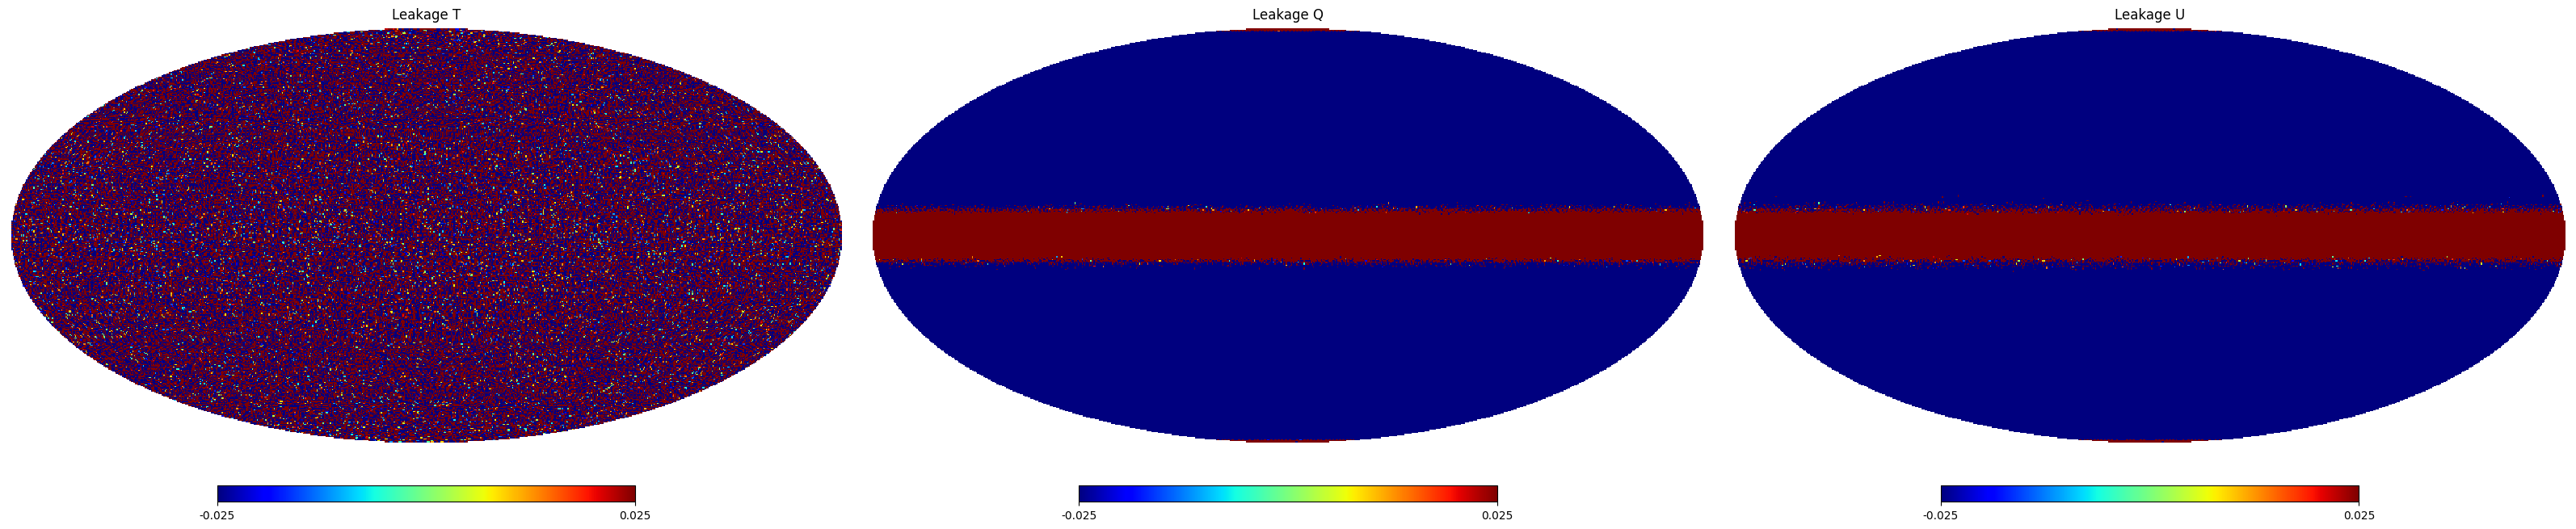

In [ ]:
plt.figure(figsize=(32, 10))
stokes_parameters = ["T", "Q", "U"]
for i in range(3):
    hp.mollview(
        (output_maps[i] - input_maps[i]) * 1e6,
        cmap="jet",
        min=-0.025,
        max=0.025,
        sub=(1, 3, i + 1),
        title="Leakage " + stokes_parameters[i],
    )